# Reverse DCF Solver

This notebook will walk through the process of retrieveing market data, and running a reverse dcf on a company. Thus getting implied growth

## Some Math  
Begin with the DCF model, where a company is modelled using its cash flows. Let $0 \leq i \leq n$ be our time steps. We will consider a company with  
- $c_i$ is cashflow at time $i$  
- $r_i$ is the discount rate at time $i$  
- $M$ is the market cap of the stock  
We can recover the price of a stock by $p = M / k$, where $p$ is the share price, and $k$ is the number of shares outstanding. We will assume that the current price is the sum of the discounted price of all future cash flows, i.e.  
\begin{equation}  
M = \sum_{i = 0}^{n} \dfrac{c_i}{(1+r_i)^i}
\end{equation}  
What we wish to do is *given* $M$ what can $c_i$ and $r_i$ be? Using this we can inform the investor what the market is pricing in.  
  

Let's simplify the problem, we will assume  
> Growth is constant year over year, i.e. $c_{i+1} = (1+g)c_{i}$  
> Discount rate is constant, i.e. $r_i = r_j = r$  

Rewrite the DCF as  

\begin{equation}
\begin{aligned}
M &= \sum_{i = 0}^{n} \dfrac{c_i}{(1+r_i)^i} \\ 
M &= \sum_{i = 0}^{n} \dfrac{c_0(1+g)^i}{(1+r)^i} \\
M &= c_0 \sum_{i = 0}^{n} \bigg ( \dfrac{1+g}{1+r} \bigg )^i \\
\end{aligned}
\end{equation}  
For the sake of brevity, let $x = \dfrac{1+g}{1+r}$. Next, use the geometric sum formula : $\sum^n_{j=0} x^j = \dfrac{x^{n+1} - 1}{x - 1}$  

\begin{equation}
\begin{aligned}
M &= c_0 \cdot \dfrac{x^{n+1} - 1}{x - 1} \\
M(x-1) &= c_0(x^{n+1} - 1) \\
0 &= c_0 x^{n+1} - Mx + (M - c_0)
\end{aligned}  
\end{equation}    

We now have a $n+1$ degree polynomial, we will use a solver to get us roots. We will discard imaginery roots (since an imagnery root would require imagenery discount rate or growth). Let our real roots be denoted as $x_1, x_2, ... , x_l$. Rearange the equation for $x$,  
\begin{equation}
\begin{aligned}
x &= \dfrac{1+g}{1+r} \\
x + rx &= 1+g \\
g &= x + rx - 1
\end{aligned}
\end{equation}
Do this for each of $x_1,...,x_l$, and we have a set of possible growths. Further constraints are needed to cut down on the set of answers.  
One possible constraint is that $0 < x$, as a negative ratio would imply that exactly one of $g$ or $r$ is < -1. Moreover, $x=1$ is always a solution, so we can throw that case out.  
So if we calculate that $g > r, \forall r$, this would means that the implied growth of the company will always beat the discount rate, no matter what it is. This could be useful. A quick way to figure this out would be to let $g > r$, then   
\begin{equation}
\begin{aligned}
g &> r \\
x + rx - 1 &> r \\
x(1+r) &>r + 1 \\
x &> 1 \\ 
\end{aligned}
\end{equation}
If $x > 1$ then $g > r$. This means the market believes that this company will beat the discount rate in terms of growth, this infomation is *already priced in*.


# How to run this code  
Download the below dependencies:
```bash
pip3 install edgartools
pip3 install yfinance
pip3 install scipy
pip3 install matplotlib 
```
Run!

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import yfinance as yf
import edgar
from edgar import Company
edgar.set_identity("malganisinferno@gmail.com")

In [7]:
def get_cf(company_ticker : str) -> float:
    """
    WARNING!! Does not work for all companies, need to make it compatible with all
    Get the companys most recent cash flow
    """
    #set the name of the compan
    company = Company(company_ticker)
    # 10-K is the anual report
    filings = company.get_filings(form='10-K').latest()

    #parse the data
    xbrl = filings.xbrl()
    statements = xbrl.statements 
    
    financials = company.get_financials()

    cap_ex = financials.get_capital_expenditures()


    #get a dataframe of cash flows
    cf_df = statements.cashflow_statement().to_dataframe()

    #find the latest one
    op_cf_row = cf_df[cf_df['label'] == 'Net Cash from Operating Activities']
    latest_opcf_date = op_cf_row.columns.sort_values()[2] #assume they list 3 most recent years
    op_cf = op_cf_row[latest_opcf_date].values[0] # get the row and extract the number

    #simple formula
    free_cf = op_cf - cap_ex

    return free_cf

def get_dcf_vars(company_ticker : str) -> tuple[float, float]:
    """
    Given a companys ticker return to the user:
    -Market Cap
    -Latest cash flow
    """

    ticker = yf.Ticker(company_ticker)
    market_cap = ticker.info['marketCap']

    c_0 = get_cf(company_ticker)
    
    return market_cap, c_0

In [8]:
def find_ratio(c_0 : float, M : float, n : float):
    """
    Given the initial cashflow, market cap and number of time periods,
    set up and solve the rdcf polynomial of the form
    0=c_0*x^{n+1} - M*x + (M - c_0)
    """
    coeffs = [c_0] + [0]*(n-1) + [-M, M-c_0]
    return np.roots(coeffs)

def get_growth(x : float, r : float):
    """
    Return the growth given the ratios and discount rate
    g = x + r*x - 1
    """
    return x + r*x - 1

In [65]:
company_ticker = 'MSFT'
M, c_0 = get_dcf_vars(company_ticker)
n = 40 # NOTE there are 4 quarters in a year, the cash flow data is quarterly, thus n refers to quarters
ratios = find_ratio(c_0, M, n)
real_ratios = ratios.real[abs(ratios.imag)<1e-5]
cond1 = real_ratios > 0
cond2 = np.isclose(real_ratios, 1)
real_ratios = real_ratios[cond1 & ~cond2][0]


In [66]:
real_ratios	

np.float64(1.0132796480573358)

In [67]:
print("Most recent cash flow : {:,}".format(c_0)  )
print("Market Cap : {:,}".format(M))

Most recent cash flow : 71,611,000,000.0
Market Cap : 3,869,260,120,064


In [68]:
r = 0.04
g_arr = get_growth(real_ratios, r)
print(f"The possible implied growths for {company_ticker}, given a discount rate of{r * 100: .2f} % are:")
print(f"{g_arr * 100: .2f} %")

print(f"of {n} quarters of QoQ growth")

The possible implied growths for MSFT, given a discount rate of 4.00 % are:
 5.38 %
of 40 quarters of QoQ growth


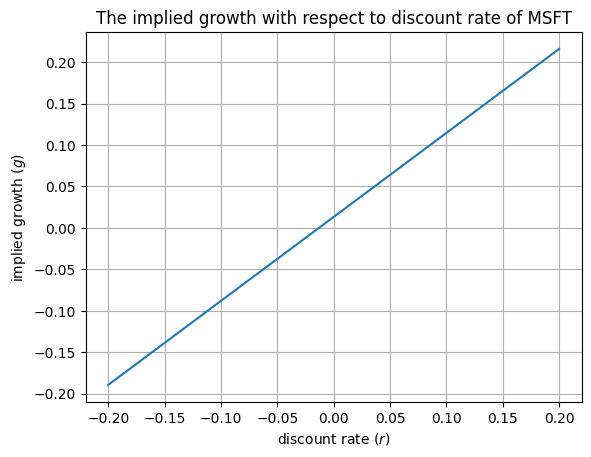

In [69]:
x = np.linspace(-0.2, 0.2, 1000)
y = get_growth(real_ratios, x)
plt.title(f"The implied growth with respect to discount rate of {company_ticker}")

plt.xlabel(r"discount rate ($r$)")
plt.ylabel(r"implied growth ($g$)")
plt.grid()
plt.plot(x,y)